# Stochastic Variational Inference in the TrueSkill Model


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [46]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

## Implementing the TrueSkill Model



In [47]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

In [48]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

In [49]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## Stochastic Variational Inference on Two Players and Toy Data




In [131]:
def diag_gaussian_samples(mean, log_std, num_samples):

    epsilon = torch.randn(num_samples, mean.shape[0])

    # Transform the samples using the mean and log_std
    samples = mean + epsilon * torch.exp(log_std)

    return samples


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)

    return Normal(mean, torch.exp(log_std)).log_prob(x).sum(-1)


def batch_elbo(logprob, mean, log_std, num_samples):

    samples = diag_gaussian_samples(mean, log_std, num_samples)
    logp = logprob(samples)
    log_q = diag_gaussian_logpdf(samples, mean, log_std)
    elbo = (logp - log_q).mean()
    return elbo

In [132]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.

  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, params[0], params[1], num_samples_per_iter)

Optimizing variational parameters...


  7%|▋         | 56/800 [00:00<00:01, 499.27it/s]

Iteration 0 lower bound 17.6228991600518
Iteration 25 lower bound 11.155885664049476
Iteration 50 lower bound 13.484901835170922
Iteration 75 lower bound 6.960411103791132
Iteration 100 lower bound 8.58791120579522
Iteration 125 lower bound 5.641668777500735
Iteration 150 lower bound 6.034049894066117


 20%|██        | 161/800 [00:00<00:00, 805.60it/s]

Iteration 175 lower bound 4.929450297298477

 48%|████▊     | 383/800 [00:00<00:00, 1007.84it/s]


Iteration 200 lower bound 3.374206294849933
Iteration 225 lower bound 4.310730969262346
Iteration 250 lower bound 4.658822394870018
Iteration 275 lower bound 3.4987134826575783
Iteration 300 lower bound 3.7004539372629224
Iteration 325 lower bound 3.623149054852685
Iteration 350 lower bound 3.6706000960180503
Iteration 375 lower bound 3.070400174678055


 62%|██████▏   | 497/800 [00:00<00:00, 1049.30it/s]

Iteration 400 lower bound 2.9023365401207424
Iteration 425 lower bound 2.9407903383328913
Iteration 450 lower bound 3.0471137663523136
Iteration 475 lower bound 3.0044827369883897
Iteration 500 lower bound 2.974000205932938
Iteration 525 lower bound 3.0470314423739397
Iteration 550 lower bound 3.0513787165399013
Iteration 575 lower bound 3.1258365042769856
Iteration 600 lower bound 3.1152758076938993
Iteration 625 lower bound 2.891855032737997


100%|██████████| 800/800 [00:00<00:00, 1020.46it/s]


Iteration 650 lower bound 2.9231985220065506
Iteration 675 lower bound 2.9395072441229364
Iteration 700 lower bound 2.93990579823572
Iteration 725 lower bound 2.9494296251464176
Iteration 750 lower bound 3.1006047233746203
Iteration 775 lower bound 2.9782659089402883


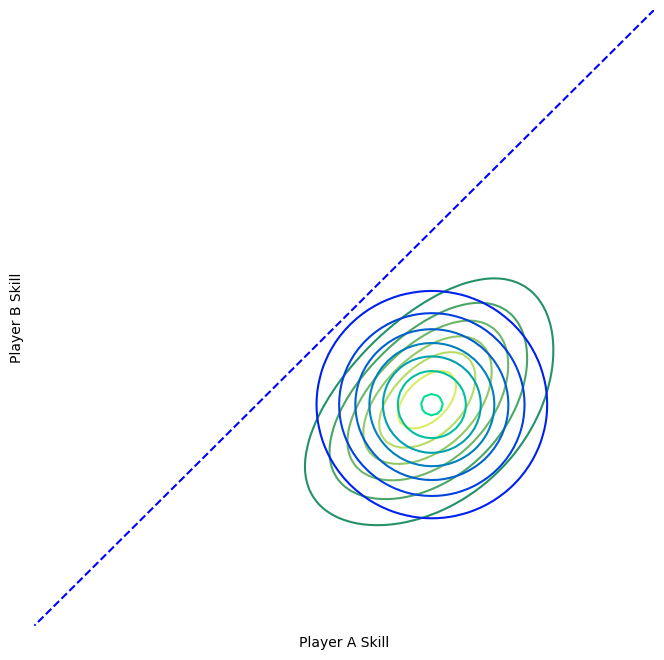

<Figure size 640x480 with 0 Axes>

In [133]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std = torch.tensor(np.ones(D), requires_grad=True)  # TODO.
init_mean = torch.tensor(np.zeros(D), requires_grad=True)  # TODO

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)



def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

In [134]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)
    z1, z2 = z1z2[:,0], z1z2[:,1]
    return log_posterior_A_beat_B_10_times(z1, z2) + log_posterior_A_beat_B_10_times(z2, z1)


def objective(params):

    return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, *params, num_samples_per_iter)

Optimizing variational parameters...


 41%|████      | 41/100 [00:00<00:00, 361.20it/s]

Iteration 0 lower bound 30.807468278644496
Iteration 25 lower bound 27.627316524421648
Iteration 50 lower bound 23.81431676494773
Iteration 75 lower bound 23.37037278190888


100%|██████████| 100/100 [00:00<00:00, 456.54it/s]


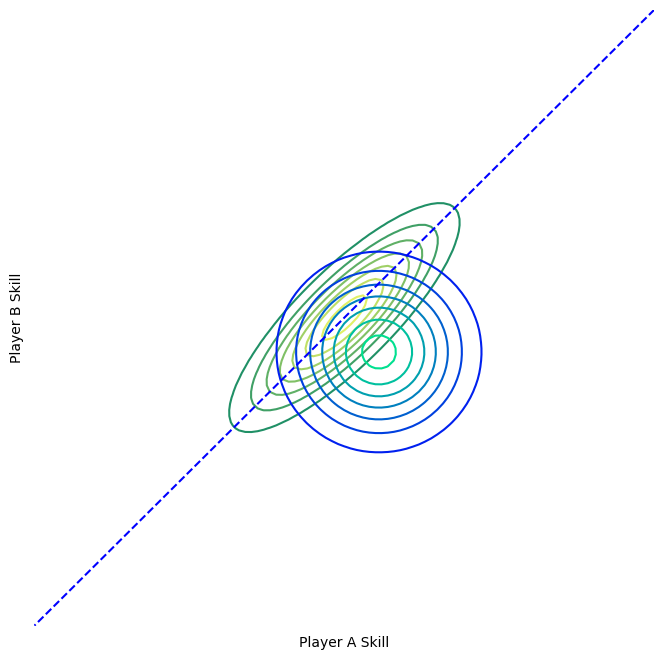

<Figure size 640x480 with 0 Axes>

In [135]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [136]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)

In [141]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [142]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

In [143]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    return -batch_elbo(log_joint_probability, *params, num_samples_per_iter)
    #return

Optimize, and report the final loss. 

In [144]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

Optimizing variational parameters...


  1%|          | 3/500 [00:00<00:16, 29.92it/s]

Iteration 0 lower bound 2296.330322265625


  6%|▌         | 30/500 [00:01<00:20, 23.16it/s]

Iteration 25 lower bound 2201.480712890625


 11%|█         | 55/500 [00:02<00:16, 26.95it/s]

Iteration 50 lower bound 2064.320556640625


 16%|█▌        | 79/500 [00:03<00:22, 18.66it/s]

Iteration 75 lower bound 1987.1143798828125


 21%|██        | 103/500 [00:04<00:20, 19.23it/s]

Iteration 100 lower bound 1918.9439697265625


 25%|██▌       | 127/500 [00:06<00:22, 16.47it/s]

Iteration 125 lower bound 1863.569580078125


 31%|███       | 154/500 [00:07<00:18, 19.14it/s]

Iteration 150 lower bound 1815.380615234375


 36%|███▌      | 178/500 [00:08<00:14, 22.04it/s]

Iteration 175 lower bound 1780.931640625


 41%|████      | 204/500 [00:09<00:12, 23.06it/s]

Iteration 200 lower bound 1749.8310546875


 45%|████▌     | 227/500 [00:11<00:18, 14.84it/s]

Iteration 225 lower bound 1723.1265869140625


 51%|█████     | 256/500 [00:12<00:07, 31.52it/s]

Iteration 250 lower bound 1700.339111328125


 56%|█████▌    | 280/500 [00:13<00:06, 32.95it/s]

Iteration 275 lower bound 1683.1063232421875


 62%|██████▏   | 310/500 [00:13<00:04, 41.39it/s]

Iteration 300 lower bound 1665.9718017578125


 66%|██████▌   | 328/500 [00:14<00:05, 33.40it/s]

Iteration 325 lower bound 1652.5074462890625


 71%|███████▏  | 357/500 [00:15<00:04, 35.68it/s]

Iteration 350 lower bound 1642.1964111328125


 76%|███████▋  | 382/500 [00:15<00:03, 34.93it/s]

Iteration 375 lower bound 1631.7254638671875


 81%|████████  | 406/500 [00:16<00:02, 36.53it/s]

Iteration 400 lower bound 1620.025146484375


 86%|████████▌ | 430/500 [00:17<00:01, 36.99it/s]

Iteration 425 lower bound 1615.090087890625


 91%|█████████ | 455/500 [00:18<00:01, 29.73it/s]

Iteration 450 lower bound 1607.0892333984375


 96%|█████████▌| 479/500 [00:18<00:00, 29.81it/s]

Iteration 475 lower bound 1599.5665283203125


100%|██████████| 500/500 [00:19<00:00, 25.72it/s]


Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

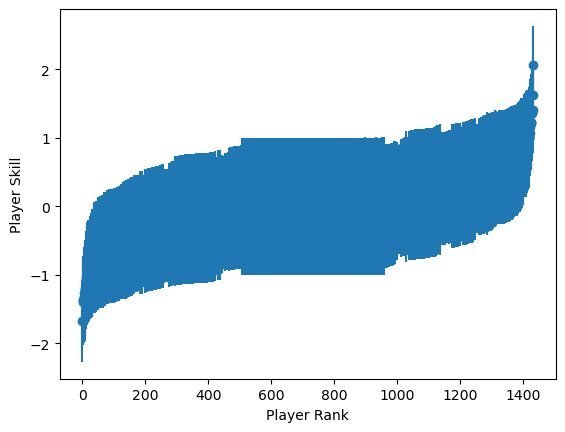

In [146]:
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], yerr=torch.exp(logstd_skills[order]), fmt='o')

List the names of the 10 players with the highest mean skill under the variational model.

In [156]:
sorted_means, order = torch.sort(mean_skills, descending=True)

list_10_highest_mean_skills = []
for i in range(10):
    list_10_highest_mean_skills.append(names[order[i].item()][1])

print(list_10_highest_mean_skills)

['doraemon61', 'laode_syahril', 'projetoxadrez', 'mrzoom47', 'chesswithmom', 'cdvh', 'hick4u1219', 'smartduckduckcow', 'sneaky_bugger', 'lzchips']


[496 'lelik3310']
[512 'thebestofthebad']


TypeError: 'torch.Size' object is not callable

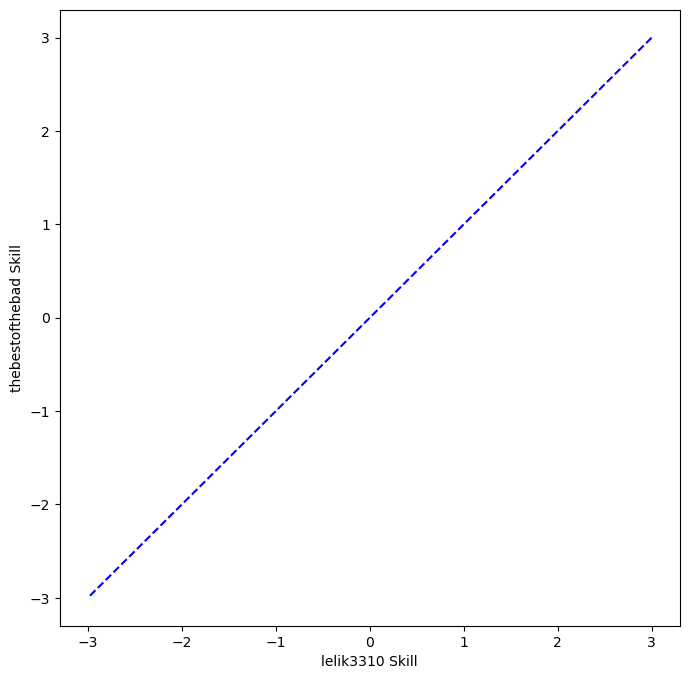

In [160]:
lelik3310_ix = 496
thebestofthebad_ix = 512
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
#IndexError: index 496 is out of bounds for dimension 0 with size 100


if lelik3310_ix >= num_players or thebestofthebad_ix >= num_players:
    print("Error: One or more indices are out of bounds.")

plt.scatter(samples[lelik3310_ix], samples[thebestofthebad_ix])
plt.show()

#plt.scatter(samples[lelik3310_ix], samples[thebestofthebad_ix])
#plt.show()


The probability over two players’ skills that one has higher skill than the other is given by:
$$ P(A > B) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \mathcal N(y_A, \sigma_A^2) \mathcal N(y_B, \sigma_B^2) \mathbb 1_{y_A > y_B} dy_A dy_B $$
$$ = \int_{-\infty}^{\infty} \mathcal N(y_A, \sigma_A^2) \int_{-\infty}^{y_A} \mathcal N(y_B, \sigma_B^2) dy_B dy_A $$
$$ = \int_{-\infty}^{\infty} \mathcal N(y_A, \sigma_A^2) \Phi\left(\frac{y_A - \mu_B}{\sigma_B}\right) dy_A $$
$$ = \Phi\left(\frac{\mu_A - \mu_B}{\sqrt{\sigma_A^2 + \sigma_B^2}}\right) $$


In [162]:
def prob_A_superior_B(N, A_ix, B_ix):
    #formula_est = 0
    #mc_est = 1

    # Exact formula
    mu_A = mean_skills[A_ix]
    mu_B = mean_skills[B_ix]
    sigma_A = torch.exp(logstd_skills[A_ix])
    sigma_B = torch.exp(logstd_skills[B_ix])
    formula_est = Normal(0,1).cdf((mu_A - mu_B) / torch.sqrt(sigma_A**2 + sigma_B**2))

    # Monte Carlo
    samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
    mc_est = (samples[A_ix] > samples[B_ix]).float().mean()


    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9861303567886353
Simple MC Estimate: 0.5153416991233826


Computes the probability that lelik3310 is better than the player with the 5th lowest mean skill.

In [163]:
# TODO
fifth_worst_ix = order[-5]
formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")



Exact CDF Estimate: 0.9621281623840332
Simple MC Estimate: 0.48465830087661743


VAE with synthetic data

Function below generates the synthetic spiral data.

In [164]:
# Code to generate the pinwheel dataset.
# Taken from [Johnson et al (2016)], updated by Zhao & Linderman.
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = torch.linspace(0, 2*torch.pi, num_classes + 1)

    features = torch.randn(num_classes*num_per_class, 2) * torch.tensor([radial_std, tangential_std])
    print(features)
    features[:, 0] = features[:, 0] + 1.0
    labels = torch.repeat_interleave(torch.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * torch.exp(features[:,0])
    rotations = torch.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = torch.reshape(rotations.T, (-1, 2, 2))

    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], torch.einsum('ti,tij->tj', features, rotations)[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

tensor([[-0.0391,  0.0989],
        [-0.0375, -0.1304],
        [ 0.0997,  0.0187],
        ...,
        [ 0.1049, -0.1647],
        [-0.1434,  0.0755],
        [-0.3814, -0.0614]])


(-1.8408561050891876,
 2.2923296988010406,
 -1.8789332568645478,
 1.4756833970546723)

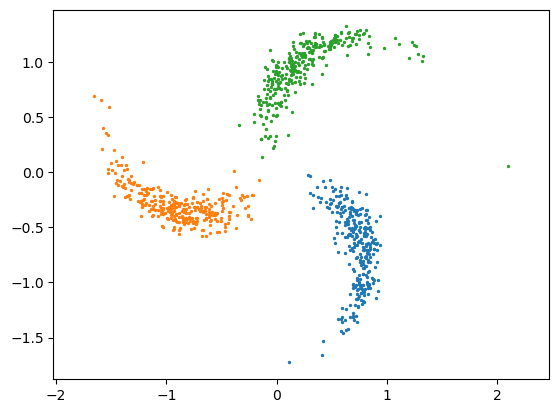

In [65]:
num_clusters = 3           
samples_per_cluster = 300
labels, data = make_pinwheel_data(0.3, 0.1, num_clusters, samples_per_cluster, 0.25)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

In [66]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):

    mean, std = recognition_net.forward(data)

    zs_array = diag_gaussian_samples(mean, std, num_samples=samples_per_cluster)

    joint = log_joint(decoder_net, zs_array, data)

    log_posterior = diag_gaussian_logpdf(zs_array, mean, std)

    elbo = joint - log_posterior

    # compute monte carlo estimate
    monte_carlo_elbo = torch.mean(elbo)
    return monte_carlo_elbo


In [67]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because 
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3120\2051871202.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  1%|          | 12/2000 [00:00<00:18, 110.13it/s]

Iteration 0 lower bound -53.72399139404297


  6%|▌         | 122/2000 [00:00<00:10, 174.91it/s]

Iteration 100 lower bound -3.2103524208068848


 12%|█▏        | 234/2000 [00:01<00:09, 186.58it/s]

Iteration 200 lower bound -2.098595380783081


 16%|█▌        | 315/2000 [00:01<00:10, 162.96it/s]

Iteration 300 lower bound -2.055192470550537


 21%|██        | 416/2000 [00:02<00:13, 119.44it/s]

Iteration 400 lower bound -1.6581614017486572


 26%|██▌       | 517/2000 [00:03<00:11, 125.08it/s]

Iteration 500 lower bound -1.6312484741210938


 31%|███       | 618/2000 [00:04<00:09, 144.91it/s]

Iteration 600 lower bound -1.4709545373916626


 36%|███▌      | 712/2000 [00:04<00:09, 139.89it/s]

Iteration 700 lower bound -1.3643230199813843


 41%|████      | 814/2000 [00:05<00:09, 129.74it/s]

Iteration 800 lower bound -1.377946376800537


 46%|████▌     | 920/2000 [00:06<00:08, 125.44it/s]

Iteration 900 lower bound -1.4302161931991577


 50%|█████     | 1005/2000 [00:07<00:07, 130.63it/s]

Iteration 1000 lower bound -1.3712513446807861


 56%|█████▌    | 1124/2000 [00:08<00:07, 123.40it/s]

Iteration 1100 lower bound -1.29887855052948


 61%|██████▏   | 1225/2000 [00:08<00:05, 146.45it/s]

Iteration 1200 lower bound -1.3238239288330078


 66%|██████▌   | 1318/2000 [00:09<00:05, 132.89it/s]

Iteration 1300 lower bound -1.3243317604064941


 71%|███████   | 1422/2000 [00:10<00:04, 131.32it/s]

Iteration 1400 lower bound -1.2551708221435547


 76%|███████▌  | 1520/2000 [00:11<00:03, 144.62it/s]

Iteration 1500 lower bound -1.1866867542266846


 81%|████████▏ | 1625/2000 [00:11<00:02, 159.02it/s]

Iteration 1600 lower bound -1.1543115377426147


 86%|████████▌ | 1717/2000 [00:12<00:02, 122.99it/s]

Iteration 1700 lower bound -1.3711190223693848


 91%|█████████ | 1812/2000 [00:13<00:01, 125.84it/s]

Iteration 1800 lower bound -1.2933900356292725


 96%|█████████▌| 1917/2000 [00:13<00:00, 126.53it/s]

Iteration 1900 lower bound -1.263148546218872


100%|██████████| 2000/2000 [00:14<00:00, 136.62it/s]


## Visualizing data in the latent space

(300, 2)
(300, 2)
(300, 2)


C:\Users\Admin\AppData\Local\Temp\ipykernel_3120\3773713211.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed = recognition_net(torch.tensor(cur_data))[0].detach().numpy()


Text(0, 0.5, 'latent dimension 2')

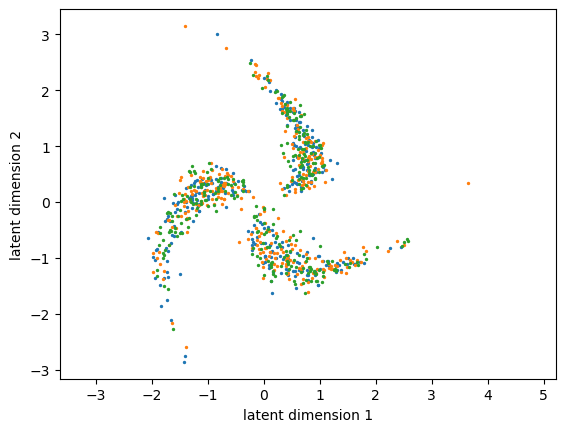

In [68]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    # cur_data =  # TODO get all the data from this cluster.
    cur_data = data[k * samples_per_cluster: (k + 1) * samples_per_cluster]
    # transformed =  # TODO find the mean of q(z|x) for each x. Remember to .detach() any tensors
    transformed = recognition_net(torch.tensor(cur_data))[0].detach().numpy()


    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
    print(transformed.shape)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

## Generating new data using the decoder and the generative model we just trained



(-1.670664781332016,
 1.4001005828380584,
 -2.3237722635269167,
 1.382315468788147)

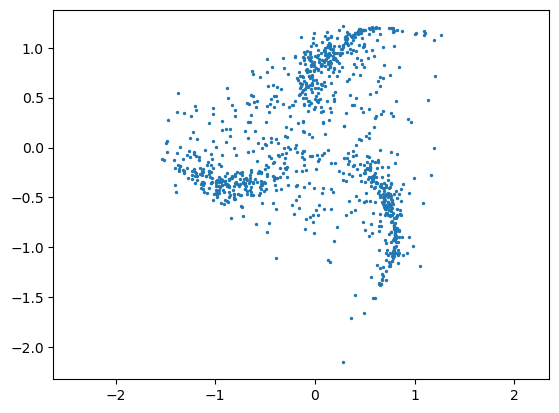

In [69]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.
sample_prior = lambda n: torch.randn(n, latent_dimension)
num_samples = 1000
samples = sample_prior(num_samples)
# samples =  # TODO
# transformed =  # TODO
transformed =   decoder_net(samples)[0].detach().numpy()


plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
plt.axis("equal")

C:\Users\Admin\Miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


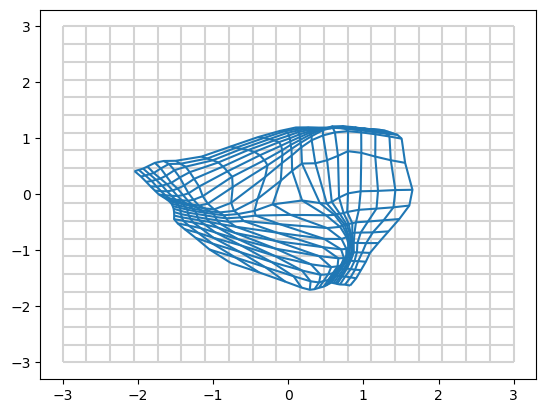

In [70]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



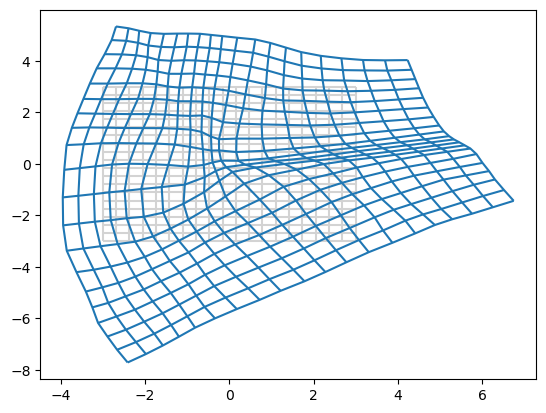

In [52]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

VAE Real Data


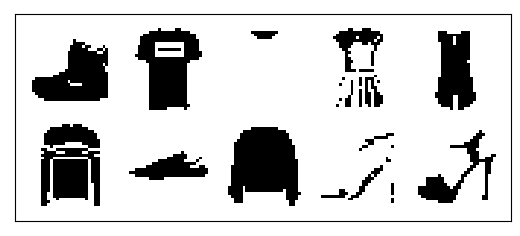

In [71]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_images, test_images = np.float32(train_images), np.float32(test_images)
    train_labels = torch.tensor(one_hot(train_labels, 10))
    test_labels = torch.tensor(one_hot(test_labels, 10))
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()

def plot_images(images, ims_per_row=5, padding=5, dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((dimensions[0] + padding) * N_rows + padding,
                             (dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + dimensions[0]) * row_ix
        col_start = padding + (padding + dimensions[1]) * col_ix
        concat_images[row_start: row_start + dimensions[0],
                      col_start: col_start + dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])


### This model is as follows:

*   **Prior:** The prior over each items's latent representation is a multivariate standard normal distribution. For all questions, we'll set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but for this assignment we'll use a two-dimensional latent space to make visualization and debugging easier.


*   **Likelihood:** Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.


In [74]:
 
 # Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

# recognition_net = RecognitionNet(YOUR-ANSWER-HERE, YOUR-ANSWER-HERE) # TODO: What are the input and output dimensions of the encoder?
recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(), nn.Linear(50, data_dimension) #, nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
    """Bernoulli log pdf of data x given logits."""
    return -torch.sum(torch.logaddexp(torch.tensor([0.]), torch.where(x > 0.5, -1., 1.) * logits), dim=1)

def log_likelihood(decoder_net, latent, data): # TODO
    log_likelihood_val = bernoulli_logpdf(decoder_net(latent), data)

    return log_likelihood_val

def log_joint(decoder_net, latent, data): # TODO

    log_joint_val = log_likelihood(decoder_net, latent, data) + torch.distributions.Normal(0, 1).log_prob(latent).sum(dim=1)
    return log_joint_val

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-2)
n_iters = 5000
minibatch_size = 200

dataset = TensorDataset(torch.tensor(train_images), )
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.  
    minibatch = next(iter(dataloader))
    data = minibatch[0]
    latent_mean, latent_log_std = recognition_net(data)
    latent_std = torch.exp(latent_log_std)
    latent = torch.distributions.Normal(latent_mean, latent_std).rsample()
    log_joint_val = log_joint(decoder_net, latent, data)
    elbo = torch.mean(log_joint_val)
    return -elbo
    #return # TODO

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

callback(n_iters)

Optimizing variational parameters...


  0%|          | 7/5000 [00:00<01:19, 62.68it/s]

Iteration 0 lower bound -532.0486450195312


  2%|▏         | 110/5000 [00:01<00:44, 108.74it/s]

Iteration 100 lower bound -195.58229064941406


  4%|▍         | 220/5000 [00:02<00:41, 114.82it/s]

Iteration 200 lower bound -208.7245635986328


  6%|▋         | 318/5000 [00:02<00:41, 113.01it/s]

Iteration 300 lower bound -197.5411376953125


  8%|▊         | 415/5000 [00:03<00:39, 115.93it/s]

Iteration 400 lower bound -181.87542724609375


 10%|█         | 512/5000 [00:04<00:39, 113.24it/s]

Iteration 500 lower bound -191.39083862304688


 12%|█▏        | 607/5000 [00:05<00:49, 89.38it/s] 

Iteration 600 lower bound -174.7882843017578


 14%|█▍        | 711/5000 [00:07<01:22, 52.22it/s]

Iteration 700 lower bound -191.17869567871094


 16%|█▌        | 809/5000 [00:09<01:19, 53.02it/s]

Iteration 800 lower bound -180.5856475830078


 18%|█▊        | 908/5000 [00:11<01:39, 41.13it/s]

Iteration 900 lower bound -189.79547119140625


 20%|██        | 1010/5000 [00:14<01:28, 44.98it/s]

Iteration 1000 lower bound -182.53807067871094


 22%|██▏       | 1106/5000 [00:16<01:26, 44.90it/s]

Iteration 1100 lower bound -181.15853881835938


 24%|██▍       | 1209/5000 [00:18<01:14, 51.07it/s]

Iteration 1200 lower bound -177.8654327392578


 26%|██▌       | 1311/5000 [00:20<01:05, 55.99it/s]

Iteration 1300 lower bound -176.7910614013672


 28%|██▊       | 1407/5000 [00:22<01:21, 44.34it/s]

Iteration 1400 lower bound -184.25088500976562


 30%|███       | 1507/5000 [00:24<01:13, 47.82it/s]

Iteration 1500 lower bound -182.03643798828125


 32%|███▏      | 1605/5000 [00:26<01:10, 47.98it/s]

Iteration 1600 lower bound -179.43357849121094


 34%|███▍      | 1711/5000 [00:28<01:04, 50.98it/s]

Iteration 1700 lower bound -169.64727783203125


 36%|███▌      | 1806/5000 [00:30<01:10, 45.61it/s]

Iteration 1800 lower bound -164.14866638183594


 38%|███▊      | 1906/5000 [00:33<01:33, 33.23it/s]

Iteration 1900 lower bound -173.6703338623047


 40%|████      | 2006/5000 [00:36<01:29, 33.61it/s]

Iteration 2000 lower bound -174.8300323486328


 42%|████▏     | 2104/5000 [00:39<01:23, 34.62it/s]

Iteration 2100 lower bound -174.47279357910156


 44%|████▍     | 2204/5000 [00:42<01:13, 38.23it/s]

Iteration 2200 lower bound -162.19017028808594


 46%|████▌     | 2307/5000 [00:44<01:10, 38.09it/s]

Iteration 2300 lower bound -176.20738220214844


 48%|████▊     | 2405/5000 [00:47<01:08, 37.74it/s]

Iteration 2400 lower bound -177.23788452148438


 50%|█████     | 2507/5000 [00:50<01:07, 36.71it/s]

Iteration 2500 lower bound -160.64959716796875


 52%|█████▏    | 2607/5000 [00:52<01:12, 32.95it/s]

Iteration 2600 lower bound -169.02374267578125


 54%|█████▍    | 2705/5000 [00:55<00:59, 38.29it/s]

Iteration 2700 lower bound -172.37828063964844


 56%|█████▌    | 2807/5000 [00:58<00:58, 37.50it/s]

Iteration 2800 lower bound -166.78652954101562


 58%|█████▊    | 2905/5000 [01:00<00:57, 36.19it/s]

Iteration 2900 lower bound -179.9158172607422


 60%|██████    | 3007/5000 [01:03<00:56, 35.55it/s]

Iteration 3000 lower bound -179.56134033203125


 62%|██████▏   | 3108/5000 [01:06<00:52, 36.16it/s]

Iteration 3100 lower bound -169.98829650878906


 64%|██████▍   | 3206/5000 [01:08<00:50, 35.47it/s]

Iteration 3200 lower bound -178.31298828125


 66%|██████▌   | 3305/5000 [01:11<00:43, 39.10it/s]

Iteration 3300 lower bound -173.82275390625


 68%|██████▊   | 3407/5000 [01:14<00:45, 34.76it/s]

Iteration 3400 lower bound -176.8576202392578


 70%|███████   | 3508/5000 [01:17<00:38, 38.70it/s]

Iteration 3500 lower bound -174.73793029785156


 72%|███████▏  | 3606/5000 [01:20<00:36, 37.89it/s]

Iteration 3600 lower bound -157.4616241455078


 74%|███████▍  | 3706/5000 [01:23<00:36, 35.63it/s]

Iteration 3700 lower bound -172.30682373046875


 76%|███████▌  | 3806/5000 [01:25<00:31, 37.48it/s]

Iteration 3800 lower bound -167.80287170410156


 78%|███████▊  | 3905/5000 [01:28<00:31, 34.27it/s]

Iteration 3900 lower bound -169.04002380371094


 80%|████████  | 4006/5000 [01:31<00:27, 36.60it/s]

Iteration 4000 lower bound -171.24049377441406


 82%|████████▏ | 4106/5000 [01:34<00:25, 35.73it/s]

Iteration 4100 lower bound -175.24462890625


 84%|████████▍ | 4207/5000 [01:36<00:22, 35.53it/s]

Iteration 4200 lower bound -167.1027374267578


 86%|████████▌ | 4307/5000 [01:39<00:19, 36.04it/s]

Iteration 4300 lower bound -161.3949432373047


 88%|████████▊ | 4405/5000 [01:42<00:16, 36.87it/s]

Iteration 4400 lower bound -165.54148864746094


 90%|█████████ | 4506/5000 [01:45<00:14, 34.71it/s]

Iteration 4500 lower bound -175.5403289794922


 92%|█████████▏| 4607/5000 [01:47<00:11, 35.41it/s]

Iteration 4600 lower bound -164.33326721191406


 94%|█████████▍| 4708/5000 [01:50<00:08, 34.63it/s]

Iteration 4700 lower bound -173.29757690429688


 96%|█████████▌| 4806/5000 [01:53<00:05, 33.36it/s]

Iteration 4800 lower bound -174.0555419921875


 98%|█████████▊| 4908/5000 [01:56<00:02, 41.18it/s]

Iteration 4900 lower bound -173.3550262451172


100%|██████████| 5000/5000 [01:58<00:00, 42.33it/s]

Iteration 5000 lower bound -171.7868194580078


(-1.9139617562294007, 1.6820849061012269, -2.51846045255661, 1.523511826992035)

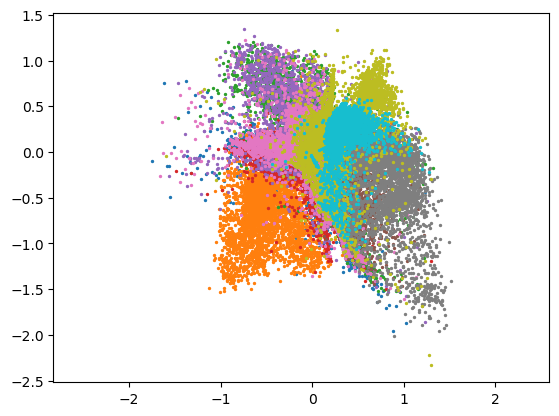

In [73]:
for k in range(10):
    cur_data = torch.tensor(train_images[train_labels[:, k] == True, :]).to(torch.float32)
    #   transformed = # TODO:  Call recognition net and extract mean, remember to .detach() the tensors!
    transformed = recognition_net(cur_data)[0].detach().numpy()
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")